# 3. 멋진 단어사전 만들기 [프로젝트]

---

## 3-1. 프로젝트 : SentencePiece 사용하기
## 3-2. 프로젝트 제출

---

## 3-1. 프로젝트 : SentencePiece 사용하기  

### **라이브러리 버전을 확인해 봅니다.**

---

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


### GOING_DEEPER LECTURE 2의 내용을 작성합니다.
Step 2의 모델 학습을 할 수 있게 하기 위함

In [2]:
# 라이브러리 임포트
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [3]:
# train 데이터 가져오기
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

In [4]:
# 데이터의 중복을 제거하고 문장 길이 확인
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


In [5]:
# 길이 조건에 맞는 문장만 선택하여 'filtered_corpus'를 획득
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

걸러진 값(`filtered_corpus`) 확인

In [6]:
filtered_corpus

['5번 청사의 수하물처리시설은 한 시간에 1만2000개의 수하물을 처리할 수 있도록 제작됐다.',
 '톰슨 파이낸셜에따르면 월스트리트의 전문가들은 메릴린치의 4.4분기 순손실이 7억210만 달러(주당 4.70)에 달할 것으로 전망했다.',
 '크라이슬러는 내년에 전기 자동차를 출시할 계획입니다.',
 '콘돌리자 라이스 미 장관은 평화 진척에 대한 믿음을 부식시킬 수 있는 어떤 것도 하지 말라고 이스라엘에 유례 없는 경고를 했다.',
 '당뇨병, 파킨슨병, 척추 부상 등을 포함한 다수의 질환을 앓고 있는 줄기세포 연구 지지자들은 부시 시대 제한이 해지되길 간절히 기다리고 있다.',
 '올해 1월부터 9월까지 총 455명이 에이즈(HIV/AIDS) 검사 결과 양성반응을 보였으며 이로써 에이즈에 감염된 한국인 수는 2,994명으로 증가했다고 보건 당국이 발표했다.',
 '이라크 바그다드 동부지역에서 미군의 오폭 사고로 수송 트럭에 타고 있던 미군 2명과 이라크인 2명이 부상했으며 가옥이 불에 탔다고 미군 관계자가 밝혔다.',
 '7월 모스크바에서 결정된 것이 명백한 이 협정의 내용은 한 의정서에 포함되어 있다.',
 '바비 찰튼, 바비 무어, 빌리 라이트, 피터 실턴이 영광의 얼굴들이다.',
 '소식통에따르면 선관위는 노대통령의 발언을 불법으로 규정하는 대신에, 노대통령에 대해 경고하는 수준에 머물 것이라고 예상된다.',
 '이번 공세에서 군은 1,000명 이상의 무장세력을 사살시켰다고 주장합니다.',
 '미국 캘리포니아 인디언웰스에서 23일(현지시간) 열린 퍼시픽라이프 오픈 여자 단식 결승전에서 톱 시드의 안나 이바노비치(세르비아)가 스베틀라나 쿠즈넷소바(러시아)를 2-0(6-46-3)으로 꺾고 대회 우승을 차지했다.',
 '401K 미국의 투자형 기업 연금제도',
 '특히 펭귄들이 C-130 헤라클레스 군용 비행기에 탑승하는 것은 더 특이하다.',
 '코백은 “호킨스의 유서를 발견했으며 그의 어머니에게 연락했다”고 말했다.',
 '이후 경기는 비로 중단됐으며 

#### **Step 1. SentencePiece 설치하기**
아래 링크에서 세부 내용 확인 가능
- [google/sentencepiece](https://github.com/google/sentencepiece)

SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화  
최근 pretrained model들이 대부분 tokenizer로 채용하여 사실상 표준의 역할을 수행중 
아래와 같이 설치를 진행, SentencePiece는 python wrapper가 존재함
```shell
$ pip install sentencepiece
```

In [7]:
!pip install sentencepiece

In [8]:
!pip list | grep sentencepiece

sentencepiece                 0.1.96


#### **Step 2. SentencePiece 모델 학습**
앞서 배운 `tokenizer()`  
```python
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```

`tf.keras.preprocessing.text.Tokenizer`에 corpus를 주고 `tokenizer.fit_on_texts(corpus)`를 하면 토크나이저 내부적으로 토크나이저 기능을 corpus에 맞춤형으로 자동 생성

In [9]:
# SentencePiece 모델 학습
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

def sp_train(model_type=None):
    # 불용어 설정
    ## 참고1: https://github.com/google/sentencepiece/blob/master/doc/special_symbols.md?plain=1
    ## 참고2: https://wikidocs.net/44249
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    ## stopwords 값들을 하나의 문장으로 엮음
    stopwords_sen = ','.join(stopwords)
    ## 명령어 옵션 추가, 불용어
    commanderize = ''.join(['--user_defined_symbols=', stopwords_sen])
    
    ## 초기 명령어 샘플
    init_command = '--input={} --model_prefix=korean_spm --model_type=unigram --vocab_size={} --minloglevel={}'
    
    ## 적용할 명령어, default is 'unigram'
    command = ' '.join([init_command, commanderize])
    
    ### --input={} --model_prefix=korean_spm --model_type=unigram --vocab_size={} 
    ### --minloglevel={}
    ### --user_defined_symbols=의,가,이,은,들,는,좀,잘,걍,과,도,를,으로,자,에,와,한,하다
    
    ## minloglevel 값, 단어 빈도수 조절, 입력된 값 미만인 단어는 무시함
    word_frequency = 2
    
    if model_type == 'bpe':
        command = command.replace('--model_type=unigram', '--model_type=bpe')
           
    
    with open(temp_file, 'w') as f:
        
        for row in filtered_corpus:# 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
            f.write(str(row) + '\n')

        spm.SentencePieceTrainer.Train(
            command.format(temp_file, vocab_size, word_frequency)    
        )
        #위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

        !ls -l korean_spm*

        ## 모델 학습 완료 후 korean_spm.model 파일과 korean_spm.vocab 파일이 생성됨을 확인 가능

# 기본값 (model_type = unigram)으로 함수 실행
sp_train()

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --model_type=unigram --vocab_size=8000 --minloglevel=2 --user_defined_symbols=의,가,이,은,들,는,좀,잘,걍,과,도,를,으로,자,에,와,한,하다


-rw-r--r-- 1 root root 374995 Aug 16 19:27 korean_spm.model
-rw-r--r-- 1 root root 144078 Aug 16 19:27 korean_spm.vocab


학습된 SentencePiece 모델을 활용하는 예시

In [10]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1123, 4, 231, 17, 7, 67, 4, 71, 27, 22]
['▁아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### **Step 3. Tokenizer 함수 작성**
SentencePiece 모델을 활용하여 위와 유사한 기능을 하는 `sp_tokenize()`를 정의하려 함  
하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게 정의하기는 어렵다. 그러니 아래 조건을 만족하는 함수를 정의하도록 한다.

1. 매개변수로 토큰화된 문장의 `list`를 전달하는 대신 온전한 문장의 `list`를 전달합니다.
2. 생성된 vocab 파일을 읽어와 `{ <word> : <idx> }`형태를 가지는 `word_index` 사전과 `{ <idx> : <word> }` 형태를 가지는 `index_word` 사전을 생성하고 함께 반환합니다.
3. 리턴값인 `tensor`는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

#### sentence_piece 방식의 tokenizer 함수 `sp_tokenize()` 선언

In [11]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

#### `fitered_corpus` 말뭉치로 함수 실행 후 반환값 확인

In [12]:
sp_tokenize(s, filtered_corpus)

(array([[ 151,   68, 5050, ...,    0,    0,    0],
        [5623,   21,  146, ...,    0,    0,    0],
        [2851,    5, 2131, ...,    0,    0,    0],
        ...,
        [  37, 2328,   21, ...,    0,    0,    0],
        [  63,    6,   21, ...,    0,    0,    0],
        [ 127,   92,    8, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '의': 3,
  '가': 4,
  '이': 5,
  '은': 6,
  '들': 7,
  '는': 8,
  '좀': 9,
  '잘': 10,
  '걍': 11,
  '과': 12,
  '도': 13,
  '를': 14,
  '으로': 15,
  '자': 16,
  '에': 17,
  '와': 18,
  '한': 19,
  '하다': 20,
  '▁': 21,
  '.': 22,
  '을': 23,
  '서': 24,
  ',': 25,
  '고': 26,
  '다': 27,
  '로': 28,
  '인': 29,
  '▁것': 30,
  '일': 31,
  '▁“': 32,
  '지': 33,
  '”': 34,
  '(': 35,
  ')': 36,
  '▁그': 37,
  '하': 38,
  '했다': 39,
  '기': 40,
  '명': 41,
  '▁있다': 42,
  '할': 43,
  '게': 44,
  '라고': 45,
  '▁수': 46,
  '사': 47,
  '주': 48,
  '나': 49,
  '▁밝혔다': 50,
  '년': 51,
  '▁있': 52,
  '▁말했다': 53,
  '라': 54,
  '하고': 55,
  '해': 56,
  '스': 57,
  '만': 58,


#### **Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기**
[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 fasttext(https://wikidocs.net/22883) 로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

##### 네이버 영화리뷰 다운로드
[참고 Link](https://wikidocs.net/44249)

`urllib` 모듈을 사용하여 데이터 다운로드

In [13]:
import urllib.request

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_test.txt")

('/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_test.txt',
 <http.client.HTTPMessage at 0x7fb592c7fc10>)

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_train.txt")

('/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_train.txt',
 <http.client.HTTPMessage at 0x7fb54131ca00>)

데이터 로드 (`pandas` 모듈 사용)

In [16]:
import pandas as pd


test_data = pd.read_table('/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_test.txt')
train_data = pd.read_table('/aiffel/aiffel/sp_tokenizer/naver_movies/ratings_train.txt')


In [17]:
# 훈련용 리뷰 개수 확인
print('훈련용 리뷰 개수 :',len(train_data))

# 상위 5개 훈련 데이터 샘플 확인
train_data[:5]

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
# 테스트 리뷰 개수 확인
print('테스트용 리뷰 개수 :',len(test_data))

# 상위 5개 테스트 데이터 샘플 확인
test_data[:5]

테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


#### 데이터 정제하기

`train_data`의 중복 데이터 제거

In [19]:
# train_data의 데이터 중복 유무 확인
## label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [20]:
## document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

중복 값이 제거된 `train_data` 길이 확인

In [21]:
# 전체 샘플 수 확인 (중복 제거 확인용)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


`train_data`에서 `Null`값이 있는지 확인

In [22]:
# 리뷰 중 null 값이 있는 샘플이 있는지를 확인
print(train_data.isnull().values.any())

True


In [23]:
# null 값이 몇 개인지를 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [24]:
# null 샘플의 위치(index) 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


확인된 `Null` 값 제거 후 결과 확인

In [25]:
# Null 값 있는 행 제거
train_data = train_data.dropna(how = 'any')

# null 값 확인
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [26]:
# 전체 샘플 수 확인 (중복값, Null값 제거됨)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146182


`train_data`의 라벨 확인 (긍정 / 부정의 데이터 분포)

<AxesSubplot:>

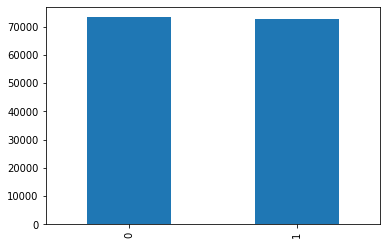

In [27]:
# train data 값 분포 현황
train_data['label'].value_counts().plot(kind = 'bar')

그래프에 나타낸 값을 수치로 확인

In [28]:
## 값 현황 파악
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72840


`train_data`의 한글 값 전처리  
1. 한글, 공백 제외하고 모두 없애기

In [29]:
# Train 데이터 한글 전처리
## 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

## 상위 5개 샘플 확인
train_data[:5]

/tmp/ipykernel_5722/412510165.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


2. 한글이 없는 리뷰를 공백(` `)으로 변경
3. 공백(` `)값을 `Null`로 변경

In [30]:
# 한글이 없는 리뷰를 대상으로 전처리
## white space 데이터를 empty value로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "")
## empty value를 null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_5722/3392940956.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


`train_data`의 `Null`값 상위 5개 확인

In [31]:
# Null 값 샘플 5개 확인
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


`Null`값 제거 (1차 전처리된 `train_data`)

In [32]:
# null 값 제거
train_data = train_data.dropna(how = 'any')
# 제거 후 train_data 개수 확인
print(len(train_data))

145393


`test_data`도 전처리
1. 중복 열 제거
2. 한글이 아닌값을 공백(` `)으로 변경
3. 공백(` `)을 `Null`로 변경
4. `Null`값이 있는 열 제거

이후 `test_data` 개수 확인

In [33]:
# test_data 전처리
## 1. 중복열 제거
test_data.drop_duplicates(subset = ['document'], inplace=True)

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49158


In [34]:
## 2. Null 값 제거
### Null 값 확인
print(test_data.isnull().values.any())

True


In [35]:
### Null 값 개수 확인
print(test_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [36]:
### Null 값 위치(index) 확인
test_data.loc[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


In [37]:
### Null 값 제거
test_data = test_data.dropna(how = 'any')

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


In [38]:
## 3. 한글과 공백을 제외하고 모두 제거 (to empty)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")

/tmp/ipykernel_5722/1420533601.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_5722/1420533601.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


In [39]:
### empty 값을 Null로 변경
test_data['document'].replace('', np.nan, inplace=True)

In [40]:
### Null 값 샘플 5개 확인
test_data.loc[test_data.document.isnull()][:5]

,id,document,label
1,9274899,NaN,0
116,6910486,NaN,1
254,4976468,NaN,0
468,7517102,NaN,0
504,2096424,NaN,0


In [41]:
### Null 값 제거
test_data = test_data.dropna(how='any')

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


`train_data`의 샘플 길이 확인

리뷰의 최대 길이 : 140
리뷰의 평균 길이 : 33.08291320765099


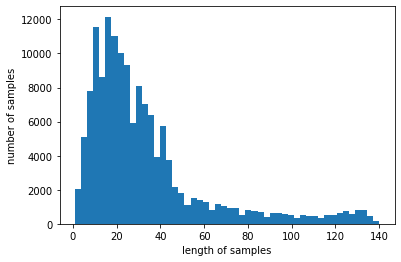

In [42]:
print('리뷰의 최대 길이 :',max(len(review) for review in train_data['document']))
print('리뷰의 평균 길이 :',sum(map(len, train_data['document']))/len(train_data['document']))
plt.hist([len(review) for review in train_data['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

`test_data`의 샘플 길이 확인

리뷰의 최대 길이 : 140
리뷰의 평균 길이 : 33.0138581839024


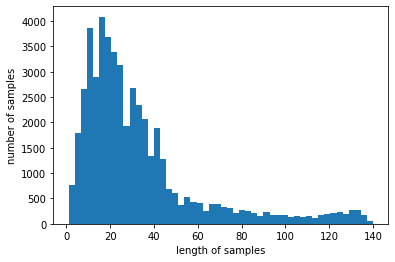

In [43]:
print('리뷰의 최대 길이 :',max(len(review) for review in test_data['document']))
print('리뷰의 평균 길이 :',sum(map(len, test_data['document']))/len(test_data['document']))
plt.hist([len(review) for review in test_data['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

데이터 샘플 비율 확인 (샘플 길이의 비율 분포)

In [44]:
# 데이터 샘플 중 특정 길이(max_len) 이하인 데이터 샘플 비율 확인하는 함수 선언
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [45]:
# 최대 샘플 길이 설정하고 데이터에서 비율 확인
## 아래는 동일 셀에서 확인한 값임
### 30일 경우 61%
### 40일 경우 76%
### 50일 경우 83%
### 60일 경우 87%
### 70일 경우 89% (pick this one)

max_len = 70
below_threshold_len(max_len, train_data['document'])

전체 샘플 중 길이가 70 이하인 샘플의 비율: 89.87502837137964


훈련 데이터(`train_data['document']`), 검증 데이터(`test_data['document']`)를 최대 길이(`max_len`)로 필터링

In [46]:
from tqdm import tqdm
# 리뷰 길이가 70 까지만 훈련하기 위해 데이터 정제
## train_data
train_movie_review = []
train_movie_label = []

for row in tqdm(train_data.iterrows(), desc="check train_data..."):
    # 행 값 추출 예시; type is Series
#     print(row[1])
    
    # 리뷰 문장
    sentence = row[1]['document']
    # 리뷰 답변 (긍정 or 부정)
    review_response = row[1]['label']
    
    # 목표 길이 (70 이하)면, 리뷰와 긍/부정 결과 append
    if len(sentence) <= max_len:
            train_movie_review.append(sentence)
            train_movie_label.append(review_response)

print("train_data filtering is done!!")

check train_data...: 145393it [00:05, 24789.91it/s]

train_data filtering is done!!


In [47]:
## test_data
test_movie_review = []
test_movie_label = []

for row in tqdm(test_data.iterrows(), desc="check train_data..."):
    # 행 값 추출 예시; type is Series
#     print(row[1])
    
    # 리뷰 문장
    sentence = row[1]['document']
    # 리뷰 답변 (긍정 or 부정)
    review_response = row[1]['label']
    
    # 목표 길이 (70 이하)면, 리뷰와 긍/부정 결과 append
    if len(sentence) <= max_len:
            test_movie_review.append(sentence)
            test_movie_label.append(review_response)

print("test_data filtering is done!!")

check train_data...: 48852it [00:01, 25326.27it/s]

test_data filtering is done!!


`train_movie_review` 샘플 분포 확인

정제된 리뷰의 최대 길이 : 70
정제된 리뷰의 평균 길이 : 25.246816456471166


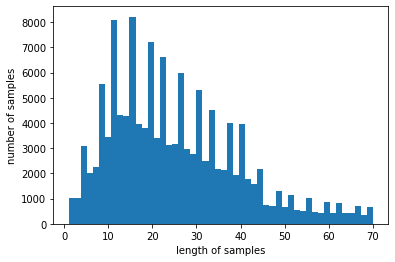

In [48]:
print('정제된 리뷰의 최대 길이 :',max(len(review) for review in train_movie_review))
print('정제된 리뷰의 평균 길이 :',sum(map(len, train_movie_review))/len(train_movie_review))
plt.hist([len(review) for review in train_movie_review], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

`test_movie_review` 샘플 분포 확인

정제된 리뷰의 최대 길이 : 70
정제된 리뷰의 평균 길이 : 25.100611007250013


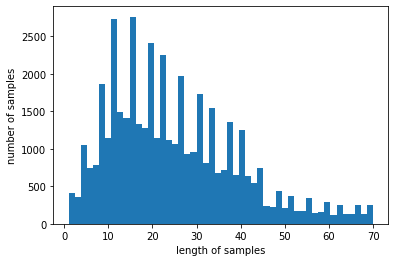

In [49]:
print('정제된 리뷰의 최대 길이 :',max(len(review) for review in test_movie_review))
print('정제된 리뷰의 평균 길이 :',sum(map(len, test_movie_review))/len(test_movie_review))
plt.hist([len(review) for review in test_movie_review], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 학습 데이터 준비

In [50]:
# 학습 데이터 세팅
X_train, _, __ = sp_tokenize(s, train_movie_review)  # s는 sp_tokenize() 모델 instance
# 검증 데이터 세팅
X_test, _, __ = sp_tokenize(s, test_movie_review)
# train_data에서 y_train, y_test 데이터 획득
## 긍정, 부정값
y_train = np.array(train_movie_label)
y_test = np.array(test_movie_label)

In [51]:
# 데이터 개수 확인
print(f"X_train 길이: {len(X_train)}, X_test 길이: {len(X_test)}")
# (130,672  43,862)

X_train 길이: 130672, X_test 길이: 43862


In [52]:
# 데이터 개수 확인
print(f"y_train 길이: {len(y_train)}, y_test 길이: {len(y_test)}")
# (130,672  43,862)

y_train 길이: 130672, y_test 길이: 43862


#### LSTM으로 영화 리뷰 김성분석

1. `RNN` 모델 구성

In [53]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 구성 (참고: https://zzcojoa.tistory.com/83)

# 어휘 사전 크기
## vocab_size 8000
# embedding vector의 차원 수
word_vector_dim = 16

## RNN --> model_rnn
model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, word_vector_dim))
model_rnn.add(LSTM(8))
model_rnn.add(Dense(8, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

# 구성한 모델 확인
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


2. `1D-CNN` 모델 구성

In [54]:
## 1D-CNN --> model_1d_cnn
# 어휘 사전 크기
## vocab_size 8000
# embedding vector의 차원 수
word_vector_dim = 16

model_1d_cnn = Sequential()
model_1d_cnn.add(Embedding(vocab_size, word_vector_dim))
model_1d_cnn.add(Conv1D(16, 3, activation='relu'))
# model_1d_cnn.add(MaxPooling1D(5))
model_1d_cnn.add(Conv1D(16, 3, activation='relu'))
model_1d_cnn.add(GlobalMaxPooling1D())
model_1d_cnn.add(Dense(8, activation='relu'))
model_1d_cnn.add(Dense(1, activation='sigmoid'))

# 구성한 모델 확인
model_1d_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 129,713
Trainable params: 129,713
Non-trainable params: 0
________________________________________________

3. `GlobalMaxPooling1D` 모델 구성

In [55]:
## GlobalMaxPooling1D --> model_gmp_1d
# 어휘 사전 크기
## vocab_size 8000
# embedding vector의 차원 수
word_vector_dim = 16

model_gmp_1d = Sequential()
model_gmp_1d.add(Embedding(vocab_size, word_vector_dim))
model_gmp_1d.add(GlobalMaxPooling1D())
model_gmp_1d.add(Dense(8, activation='relu'))
model_gmp_1d.add(Dense(1, activation='sigmoid'))

# 구성한 모델 확인
model_gmp_1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 128,145
Trainable params: 128,145
Non-trainable params: 0
_________________________________________________________________


모델 학습 후 시각화를 위한 `draw_graph()` 선언

In [56]:
# Loss, Accuracy 그래프 시각화 함수 선언
def draw_graph(history, flag):
    import matplotlib.pyplot as plt
    
    acc_title_sen = 'accuracy'
    loss_title_sen = 'loss'
    
    if flag == 'RNN' or flag == 'rnn':
        acc_title_sen = ' '.join(['RNN', acc_title_sen])
        loss_title_sen = ' '.join(['RNN', loss_title_sen])
    ## 아래 1D CNN은 실제 셀 실행 시에는 !D CNN으로 수행됨(오타였음)
    if flag == '1D CNN' or flag == '1d cnn':
        acc_title_sen = ' '.join(['1D-CNN', acc_title_sen])
        loss_title_sen = ' '.join(['1D-CNN', loss_title_sen])
    if flag == 'GMP' or flag == 'gmp':
        acc_title_sen = ' '.join(['GlobalMaxPooling', acc_title_sen])
        loss_title_sen = ' '.join(['GlobalMaxPooling', loss_title_sen])
    
    history_dict = history.history
    
    # 모델 훈련에서 사용할 metrics를 잘 봐야함
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,8))
    
    # accuracy graph
    plt.style.use('ggplot')
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(acc_title_sen)
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # loss graph
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(loss_title_sen)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

`RNN` 모델 훈련

In [57]:
## EarlyStopping 구성, 모델 훈련 (RNN)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_rnn_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
rnn_history = model_rnn.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
256/256 [==============================] - 6s 9ms/step - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5056

Epoch 00001: val_acc improved from -inf to 0.50556, saving model to best_rnn_model.h5
Epoch 2/10
256/256 [==============================] - 2s 7ms/step - loss: 0.6865 - acc: 0.5339 - val_loss: 0.6271 - val_acc: 0.6801

Epoch 00002: val_acc improved from 0.50556 to 0.68013, saving model to best_rnn_model.h5
Epoch 3/10
256/256 [==============================] - 2s 7ms/step - loss: 0.5187 - acc: 0.7641 - val_loss: 0.4437 - val_acc: 0.7975

Epoch 00003: val_acc improved from 0.68013 to 0.79746, saving model to best_rnn_model.h5
Epoch 4/10
256/256 [==============================] - 2s 7ms/step - loss: 0.4336 - acc: 0.8009 - val_loss: 0.4393 - val_acc: 0.7953

Epoch 00004: val_acc did not improve from 0.79746
Epoch 5/10
256/256 [==============================] - 2s 7ms/step - loss: 0.4185 - acc: 0.8077 - val_loss: 0.4383 - val_acc: 0.7957

Epoch 00005: val_acc 

`RNN` 모델의 `accuracy`, `loss` 값 시각화

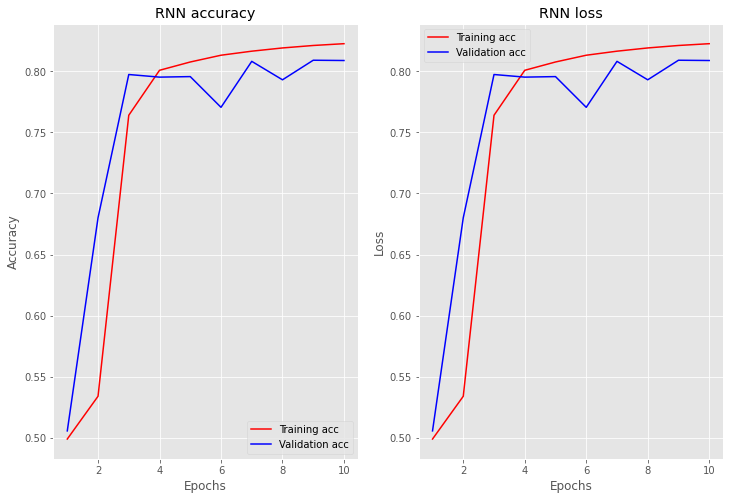

In [58]:
# RNN accuracy, loss 그래프
draw_graph(rnn_history, 'RNN')

`RNN` 모델 테스트 정확도 평가

In [59]:
# 테스트 정확도 확인 RNN
loaded_rnn_model = load_model('best_rnn_model.h5')
print("\n RNN 테스트 정확도: %.4f" % (loaded_rnn_model.evaluate(X_test, y_test)[1]))

1371/1371 [==============================] - 4s 3ms/step - loss: 0.4438 - acc: 0.8092

 RNN 테스트 정확도: 0.8092


`1D-CNN` 모델 테스트 훈련

In [60]:
## EarlyStopping 구성, 모델 훈련 (1D CNN)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_cnn_1d_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_1d_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cnn_1d_history = model_1d_cnn.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
256/256 [==============================] - 4s 7ms/step - loss: 0.5338 - acc: 0.7428 - val_loss: 0.4567 - val_acc: 0.7866

Epoch 00001: val_acc improved from -inf to 0.78660, saving model to best_cnn_1d_model.h5
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 0.4167 - acc: 0.8102 - val_loss: 0.4201 - val_acc: 0.8094

Epoch 00002: val_acc improved from 0.78660 to 0.80936, saving model to best_cnn_1d_model.h5
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 0.3929 - acc: 0.8238 - val_loss: 0.4038 - val_acc: 0.8176

Epoch 00003: val_acc improved from 0.80936 to 0.81756, saving model to best_cnn_1d_model.h5
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 0.3762 - acc: 0.8329 - val_loss: 0.3960 - val_acc: 0.8213

Epoch 00004: val_acc improved from 0.81756 to 0.82133, saving model to best_cnn_1d_model.h5
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 0.3625 - acc: 0.8400 - val_lo

`1D-CNN` 모델의 `accuracy`, `loss` 값 시각화

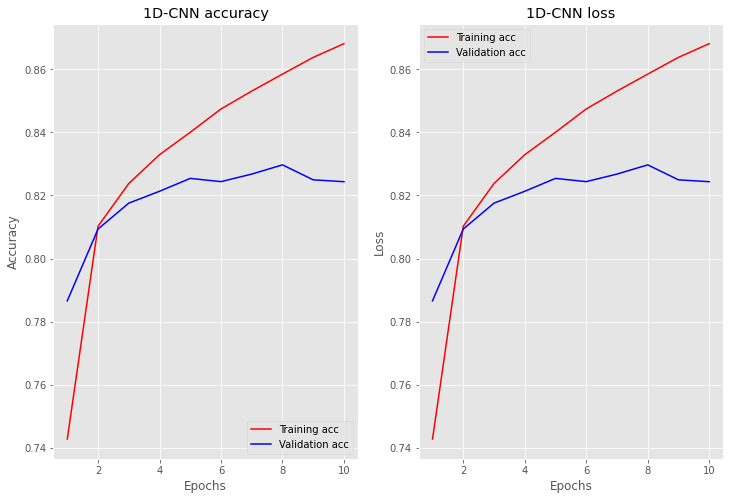

In [61]:
# 1D CNN accuracy, loss 그래프
draw_graph(cnn_1d_history, '1d cnn')

`1D-CNN` 모델 테스트 정확도 평가

In [62]:
# 테스트 정확도 확인 1D CNN
loaded_cnn_1d_model = load_model('best_cnn_1d_model.h5')
print("\n 1D CNN 테스트 정확도: %.4f" % (loaded_cnn_1d_model.evaluate(X_test, y_test)[1]))

1371/1371 [==============================] - 3s 2ms/step - loss: 0.3835 - acc: 0.8297

 1D CNN 테스트 정확도: 0.8297


`GlobalMaxPooling1D` 모델 테스트 훈련

In [63]:
## EarlyStopping 구성, 모델 훈련 (GlobalMaxPooling1D)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_gmp_1d_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_gmp_1d.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gmp_1d_history = model_gmp_1d.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
256/256 [==============================] - 2s 5ms/step - loss: 0.6048 - acc: 0.7291 - val_loss: 0.5042 - val_acc: 0.7715

Epoch 00001: val_acc improved from -inf to 0.77149, saving model to best_gmp_1d_model.h5
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 0.4553 - acc: 0.7892 - val_loss: 0.4429 - val_acc: 0.7939

Epoch 00002: val_acc improved from 0.77149 to 0.79388, saving model to best_gmp_1d_model.h5
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 0.4187 - acc: 0.8077 - val_loss: 0.4313 - val_acc: 0.7996

Epoch 00003: val_acc improved from 0.79388 to 0.79964, saving model to best_gmp_1d_model.h5
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 0.4029 - acc: 0.8172 - val_loss: 0.4265 - val_acc: 0.8044

Epoch 00004: val_acc improved from 0.79964 to 0.80439, saving model to best_gmp_1d_model.h5
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3925 - acc: 0.8229 - val_lo

`GlobalMaxPooling` 모델의 `accuracy`, `loss` 값 시각화

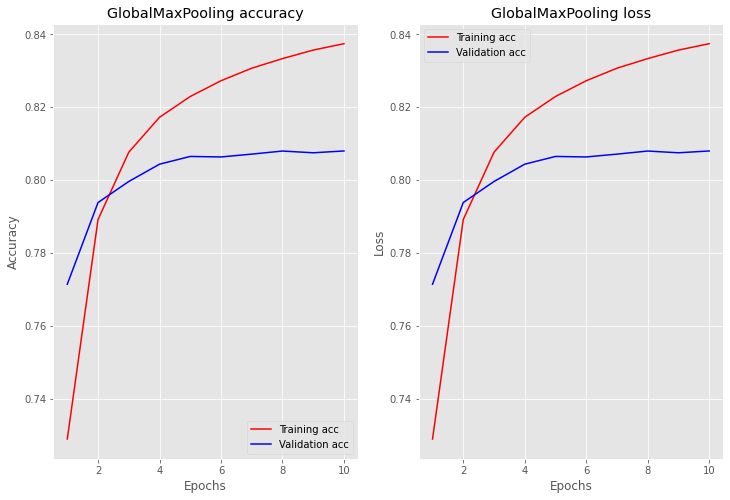

In [64]:
# GlobalMaxPooling accuracy, loss 그래프
draw_graph(gmp_1d_history, 'gmp')

`GlobalMaxPooling` 모델 테스트 정확도 평가

In [65]:
# 테스트 정확도 확인 GlobalMaxPooling
loaded_gmp_model = load_model('best_gmp_1d_model.h5')
print("\n GlobalMaxPooling 테스트 정확도: %.4f" % (loaded_gmp_model.evaluate(X_test, y_test)[1]))

1371/1371 [==============================] - 2s 2ms/step - loss: 0.4242 - acc: 0.8080

 GlobalMaxPooling 테스트 정확도: 0.8080


In [66]:
# 리뷰 예측해보는 함수 생성
def rnn_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_rnn_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        
def cnn_1d_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_cnn_1d_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))   

def gmp_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_gmp_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

#### 테스트 1번문장 (세 가지 모델 모두 테스트, 이하동일)

In [67]:
## 리뷰 예측 예제 1 - RNN case
test_sentence_1 = '이 영화 개꿀잼 ㅋㅋㅋ'
rnn_sentiment_predict(test_sentence_1)

72.19% 확률로 긍정 리뷰입니다.



In [68]:
## 리뷰 예측 예제 1 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_1)

94.21% 확률로 긍정 리뷰입니다.



In [69]:
## 리뷰 예측 예제 1 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_1)

98.02% 확률로 긍정 리뷰입니다.



#### 테스트 2번문장

In [70]:
## 리뷰 예측 예제 2 - RNN case
test_sentence_2 = '이 영화 핵노잼 ㅠㅠ'
rnn_sentiment_predict(test_sentence_2)

66.14% 확률로 부정 리뷰입니다.



In [71]:
## 리뷰 예측 예제 2 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_2)

98.69% 확률로 부정 리뷰입니다.



In [72]:
## 리뷰 예측 예제 2 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_2)

97.97% 확률로 부정 리뷰입니다.



#### 테스트 3번문장

In [73]:
# 리뷰 예측 예제 3 - RNN case
test_sentence_3 = '이딴게 영화냐 ㅉㅉ'
rnn_sentiment_predict(test_sentence_3)

72.06% 확률로 부정 리뷰입니다.



In [74]:
# 리뷰 예측 예제 3 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_3)

98.72% 확률로 부정 리뷰입니다.



In [75]:
# 리뷰 예측 예제 3 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_3)

99.41% 확률로 부정 리뷰입니다.



#### 테스트 4번문장

In [76]:
# 리뷰 예측 예제 4 - RNN case
test_sentence_4 = '감독 뭐하는 놈이냐?'
rnn_sentiment_predict(test_sentence_4)

70.77% 확률로 부정 리뷰입니다.



In [77]:
# 리뷰 예측 예제 4 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_4)

94.48% 확률로 부정 리뷰입니다.



In [78]:
# 리뷰 예측 예제 4 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_4)

94.32% 확률로 부정 리뷰입니다.



#### sentencepiece 모델 학습 옵션 변경하여 테스트

`sp_token()` 옵션 변경 후 학습

In [79]:
## sp_train()의 옵션을 default에서 `bpe`로 변경하여 수행
sp_train(model_type='bpe')

-rw-r--r-- 1 root root 370028 Aug 16 19:28 korean_spm.model
-rw-r--r-- 1 root root 115011 Aug 16 19:28 korean_spm.vocab


새로운 학습 데이터 세팅

In [80]:
import gc

## 이전에 만들어둔 데이터 메모리 점유량 낮추기 위한 처리
del X_train
del X_test
del y_train
del y_test

gc.collect()

31824

In [81]:
# 학습 데이터 세팅
bpe_X_train, _, __ = sp_tokenize(s, train_movie_review)  # s는 sp_tokenize() 모델 instance
# 검증 데이터 세팅
bpe_X_test, _, __ = sp_tokenize(s, test_movie_review)
# train_data에서 y_train, y_test 데이터 획득
## 긍정, 부정값
bpe_y_train = np.array(train_movie_label)
bpe_y_test = np.array(test_movie_label)

In [82]:
# 데이터 개수 확인
print(f"bpe_X_train,  길이: {len(bpe_X_train, )}, bpe_X_test 길이: {len(bpe_X_test)}")
# ()

bpe_X_train,  길이: 130672, bpe_X_test 길이: 43862


In [83]:
# 데이터 개수 확인
print(f"bpe_y_train 길이: {len(bpe_y_train)}, y_test 길이: {len(bpe_y_test)}")
# ()

bpe_y_train 길이: 130672, y_test 길이: 43862


`ModelCheckpoint()`에서 사용하는 `.h5` 모델명은 동일하게 작성하여 덮어버림  
`@_history` 변수도 동일한 과정  

`RNN` 모델 훈련

In [84]:
## EarlyStopping 구성, 모델 훈련 (RNN)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_rnn_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
rnn_history = model_rnn.fit(bpe_X_train, bpe_y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(bpe_X_test, bpe_y_test))

Epoch 1/10
256/256 [==============================] - 4s 8ms/step - loss: 0.3868 - acc: 0.8249 - val_loss: 0.4472 - val_acc: 0.7903

Epoch 00001: val_acc improved from -inf to 0.79034, saving model to best_rnn_model.h5
Epoch 2/10
256/256 [==============================] - 2s 7ms/step - loss: 0.3818 - acc: 0.8273 - val_loss: 0.4256 - val_acc: 0.8126

Epoch 00002: val_acc improved from 0.79034 to 0.81257, saving model to best_rnn_model.h5
Epoch 3/10
256/256 [==============================] - 2s 7ms/step - loss: 0.3791 - acc: 0.8293 - val_loss: 0.4168 - val_acc: 0.8105

Epoch 00003: val_acc did not improve from 0.81257
Epoch 4/10
256/256 [==============================] - 2s 7ms/step - loss: 0.3749 - acc: 0.8316 - val_loss: 0.4145 - val_acc: 0.8139

Epoch 00004: val_acc improved from 0.81257 to 0.81389, saving model to best_rnn_model.h5
Epoch 5/10
256/256 [==============================] - 2s 7ms/step - loss: 0.3719 - acc: 0.8330 - val_loss: 0.4607 - val_acc: 0.8081

Epoch 00005: val_acc 

`RNN` `accuracy`, `loss` 그래프

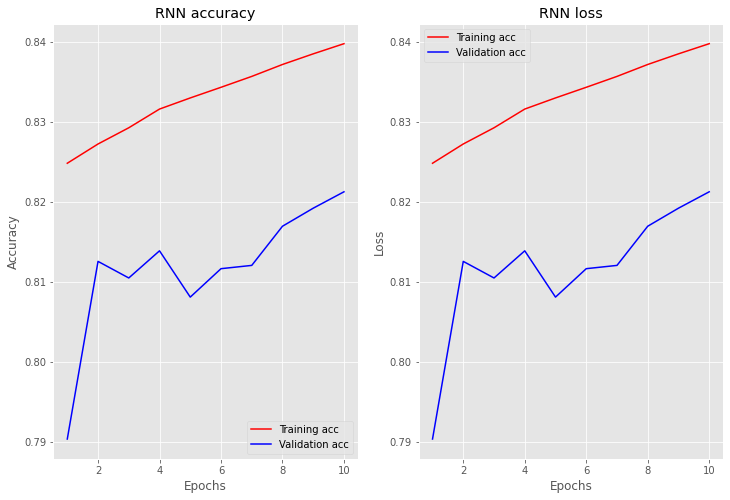

In [85]:
# RNN accuracy, loss 그래프
draw_graph(rnn_history, 'RNN')

`RNN` `accuracy` 확인

In [86]:
# 테스트 정확도 확인 RNN
loaded_rnn_model = load_model('best_rnn_model.h5')
print("\n RNN 테스트 정확도: %.4f" % (loaded_rnn_model.evaluate(bpe_X_test, bpe_y_test)[1]))

1371/1371 [==============================] - 4s 3ms/step - loss: 0.4010 - acc: 0.8213

 RNN 테스트 정확도: 0.8213


`1D-CNN` 모델 훈련

In [87]:
## EarlyStopping 구성, 모델 훈련 (1D CNN)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_cnn_1d_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_1d_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cnn_1d_history = model_1d_cnn.fit(bpe_X_train, bpe_y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(bpe_X_test, bpe_y_test))

Epoch 1/10
256/256 [==============================] - 2s 6ms/step - loss: 0.3040 - acc: 0.8725 - val_loss: 0.3856 - val_acc: 0.8320

Epoch 00001: val_acc improved from -inf to 0.83204, saving model to best_cnn_1d_model.h5
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 0.2955 - acc: 0.8766 - val_loss: 0.3880 - val_acc: 0.8307

Epoch 00002: val_acc did not improve from 0.83204
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 0.2879 - acc: 0.8809 - val_loss: 0.3909 - val_acc: 0.8297

Epoch 00003: val_acc did not improve from 0.83204
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 0.2808 - acc: 0.8846 - val_loss: 0.3954 - val_acc: 0.8280

Epoch 00004: val_acc did not improve from 0.83204
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 0.2735 - acc: 0.8884 - val_loss: 0.3921 - val_acc: 0.8303

Epoch 00005: val_acc did not improve from 0.83204
Epoch 00005: early stopping


`1D-CNN` `accuray`, `loss` 그래프

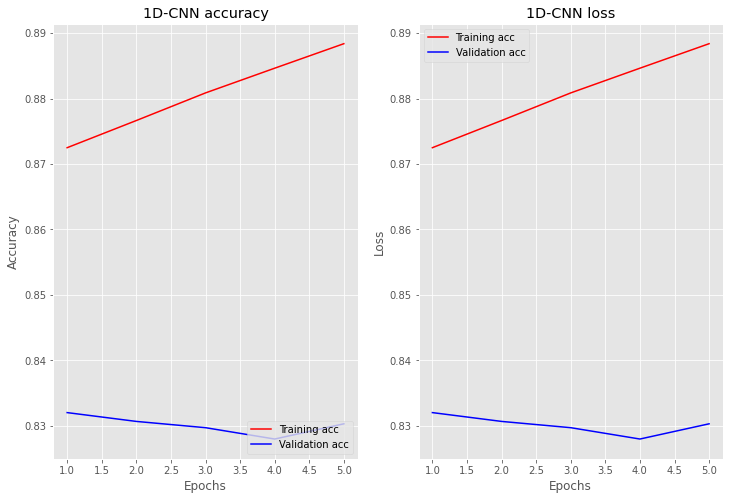

In [88]:
# 1D CNN accuracy, loss 그래프
draw_graph(cnn_1d_history, '1d cnn')

`1D-CNN` `accuracy` 확인

In [89]:
# 테스트 정확도 확인 1D CNN
loaded_cnn_1d_model = load_model('best_cnn_1d_model.h5')
print("\n 1D CNN 테스트 정확도: %.4f" % (loaded_cnn_1d_model.evaluate(bpe_X_test, bpe_y_test)[1]))

1371/1371 [==============================] - 3s 2ms/step - loss: 0.3856 - acc: 0.8320

 1D CNN 테스트 정확도: 0.8320


`GlobalMaxPooling` 모델 훈련

In [90]:
## EarlyStopping 구성, 모델 훈련 (GlobalMaxPooling1D)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_gmp_1d_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_gmp_1d.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gmp_1d_history = model_gmp_1d.fit(bpe_X_train, bpe_y_train, epochs=10, callbacks=[es, mc], batch_size=512, validation_data=(bpe_X_test, bpe_y_test))

Epoch 1/10
256/256 [==============================] - 2s 4ms/step - loss: 0.3673 - acc: 0.8387 - val_loss: 0.4237 - val_acc: 0.8081

Epoch 00001: val_acc improved from -inf to 0.80810, saving model to best_gmp_1d_model.h5
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3646 - acc: 0.8407 - val_loss: 0.4233 - val_acc: 0.8088

Epoch 00002: val_acc improved from 0.80810 to 0.80879, saving model to best_gmp_1d_model.h5
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3623 - acc: 0.8423 - val_loss: 0.4243 - val_acc: 0.8084

Epoch 00003: val_acc did not improve from 0.80879
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3604 - acc: 0.8427 - val_loss: 0.4241 - val_acc: 0.8092

Epoch 00004: val_acc improved from 0.80879 to 0.80915, saving model to best_gmp_1d_model.h5
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3586 - acc: 0.8439 - val_loss: 0.4248 - val_acc: 0.8087

Epoch 00005:

`GlobalMaxPooling` `accuracy`, `loss` 그래프

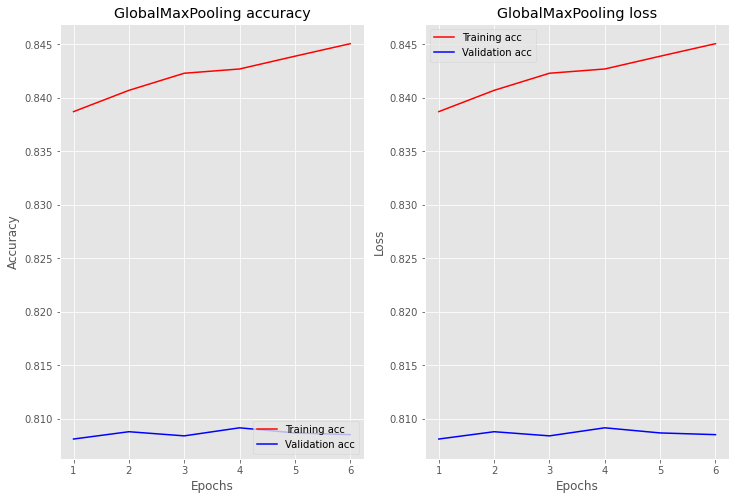

In [91]:
# GlobalMaxPooling accuracy, loss 그래프
draw_graph(gmp_1d_history, 'gmp')

`GlobalMaxPooling` `accuracy` 확인

In [92]:
# 테스트 정확도 확인 GlobalMaxPooling
loaded_gmp_model = load_model('best_gmp_1d_model.h5')
print("\n GlobalMaxPooling 테스트 정확도: %.4f" % (loaded_gmp_model.evaluate(bpe_X_test, bpe_y_test)[1]))

1371/1371 [==============================] - 2s 2ms/step - loss: 0.4241 - acc: 0.8092

 GlobalMaxPooling 테스트 정확도: 0.8092


리뷰 예측용 함수 생성

In [93]:
# 리뷰 예측해보는 함수 생성
def rnn_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_rnn_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        
def cnn_1d_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_cnn_1d_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))   

def gmp_sentiment_predict(new_sentence):
    test = [new_sentence]
    tensor, _, _ = sp_tokenize(s, test)
    score = float(loaded_gmp_model.predict(tensor)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

리뷰 테스트

In [94]:
## 리뷰 예측 예제 1 - RNN case
test_sentence_1 = '이 영화 개꿀잼 ㅋㅋㅋ'
rnn_sentiment_predict(test_sentence_1)

77.59% 확률로 긍정 리뷰입니다.



In [95]:
## 리뷰 예측 예제 1 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_1)

84.41% 확률로 긍정 리뷰입니다.



In [96]:
## 리뷰 예측 예제 1 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_1)

98.35% 확률로 긍정 리뷰입니다.



--- 

In [97]:
## 리뷰 예측 예제 2 - RNN case
test_sentence_2 = '이 영화 핵노잼 ㅠㅠ'
rnn_sentiment_predict(test_sentence_2)

78.95% 확률로 부정 리뷰입니다.



In [98]:
## 리뷰 예측 예제 2 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_2)

99.34% 확률로 부정 리뷰입니다.



In [99]:
## 리뷰 예측 예제 2 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_2)

98.25% 확률로 부정 리뷰입니다.



---

In [100]:
# 리뷰 예측 예제 3 - RNN case
test_sentence_3 = '이딴게 영화냐 ㅉㅉ'
rnn_sentiment_predict(test_sentence_3)

78.94% 확률로 부정 리뷰입니다.



In [101]:
# 리뷰 예측 예제 3 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_3)

98.86% 확률로 부정 리뷰입니다.



In [102]:
# 리뷰 예측 예제 3 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_3)

99.49% 확률로 부정 리뷰입니다.



---

In [103]:
# 리뷰 예측 예제 4 - RNN case
test_sentence_4 = '감독 뭐하는 놈이냐?'
rnn_sentiment_predict(test_sentence_4)

69.95% 확률로 부정 리뷰입니다.



In [104]:
# 리뷰 예측 예제 4 - 1D-CNN case
cnn_1d_sentiment_predict(test_sentence_4)

94.05% 확률로 부정 리뷰입니다.



In [105]:
# 리뷰 예측 예제 4 - GlobalMaxPooling case
gmp_sentiment_predict(test_sentence_4)

94.70% 확률로 부정 리뷰입니다.



## 개인 리뷰 및 생각 정리

---

초기 문제점
1. 데이터 전처리 미숙
    - max_len를 활용한 리뷰 데이터 필터링
    - y_train, y_test 세팅 시 참조한 데이터가 `train_data['label']`
        - 전처리 하지 않은 데이터를 불러버리니 데이터 길이가 다르고 난리남..
    - 초기에 label에 대해 document와 같은 조건(max_len 70)일 때, 처리해주지 못한점이 바로 위 항목과 연관있음
2. model_fit()
    - validataion_split을 제대로 체크하지 않고 막 써버린점
        - 데이터 구성상 이미 train, test로 나눠서 시작하는 상태여서 validataion_data 구성이 필요했다.
        
---

`SentencePiece` 모델 옵션에 추가해본것
1. 불용어
    - `--user_defined_symbols=` 부분 참고
2. 단어 빈도 수 조절
    - `--minloglevel` 부분 참고
    
---

체크한 내역
1. 토크나이저
    - `unigram`, `bpe` 방식의 차이가 모델 학습에서 유의미하지 않은것으로 이해됨
        - why? `accuracy`가 큰 차이 없음
2. 1D-CNN 평가 이슈
    - 모델 구성 시 `MaxPooling1D` 레이어 때문에 차원 축소가 있었다.
        - `predict()` 시에 오류 발생하였음
        - 제거 (주석처리)하여 해결
3. 모델 훈련 이슈 (전 과정은 커널 재시작을 병행함)
    - 중간 평가 시 전체 모델을 자주 재학습 시켰는데 아래 이슈가 한번 발견되었었음
        - RNN 모델의 accuracy가 80% 대역으로 확인 후, 재훈련 시 50% 대역이 한번 발견되었음
     > 추측 사항: 50% 대의 정확도 때는 EarlyStopping이 2~3회 내에 발생해버린게 아닐까 의심
     >> 반복적인 재확인이 불가능함 (현 시점 기준)
4. 리뷰 예측 예제
    - `1D-CNN`과 `GlobalMaxPooling` 기반의 학습 모델은 평가 퍼센티지가 큰 차이가 없었다.
    - `RNN`의 경우 위 두 모델에 비해 낮은 결과치를 보여주었다.